# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: Kristian Angeli Pajanonot, Kia-jüng Yang, Ina Braun 
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

torch.manual_seed(42) # Set manual seed

In [3]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [4]:
batch_size = 256
#create objects of class Compose, which I think describes how we change the images
#we import below

#constants in transforms.Normalize() are the means and standard deviations of the 
# the three color channels of the images

#random horizontal flip: flips the images randomly with a given propability

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [5]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms) 
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

#train = True creates dataset from training set, otherwise creates from test set.
#download = downloads files from internet if not already downloaded
# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.  

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset)

In [7]:
## TODO: plot images with their labels after augmentations
def show_batch(dl):
    figure = plt.figure(figsize=(20, 20))
    figure.tight_layout()
    cols, rows = 10, 10
    for i in range(1, cols * rows + 1):
        sample_idx = np.random.randint(0,len(dl.dataset), size = 1).item()
        img, label = dl.dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow((np.squeeze(img.permute(1 , 2 , 0))))  # shifts the channels to the end
    plt.show()

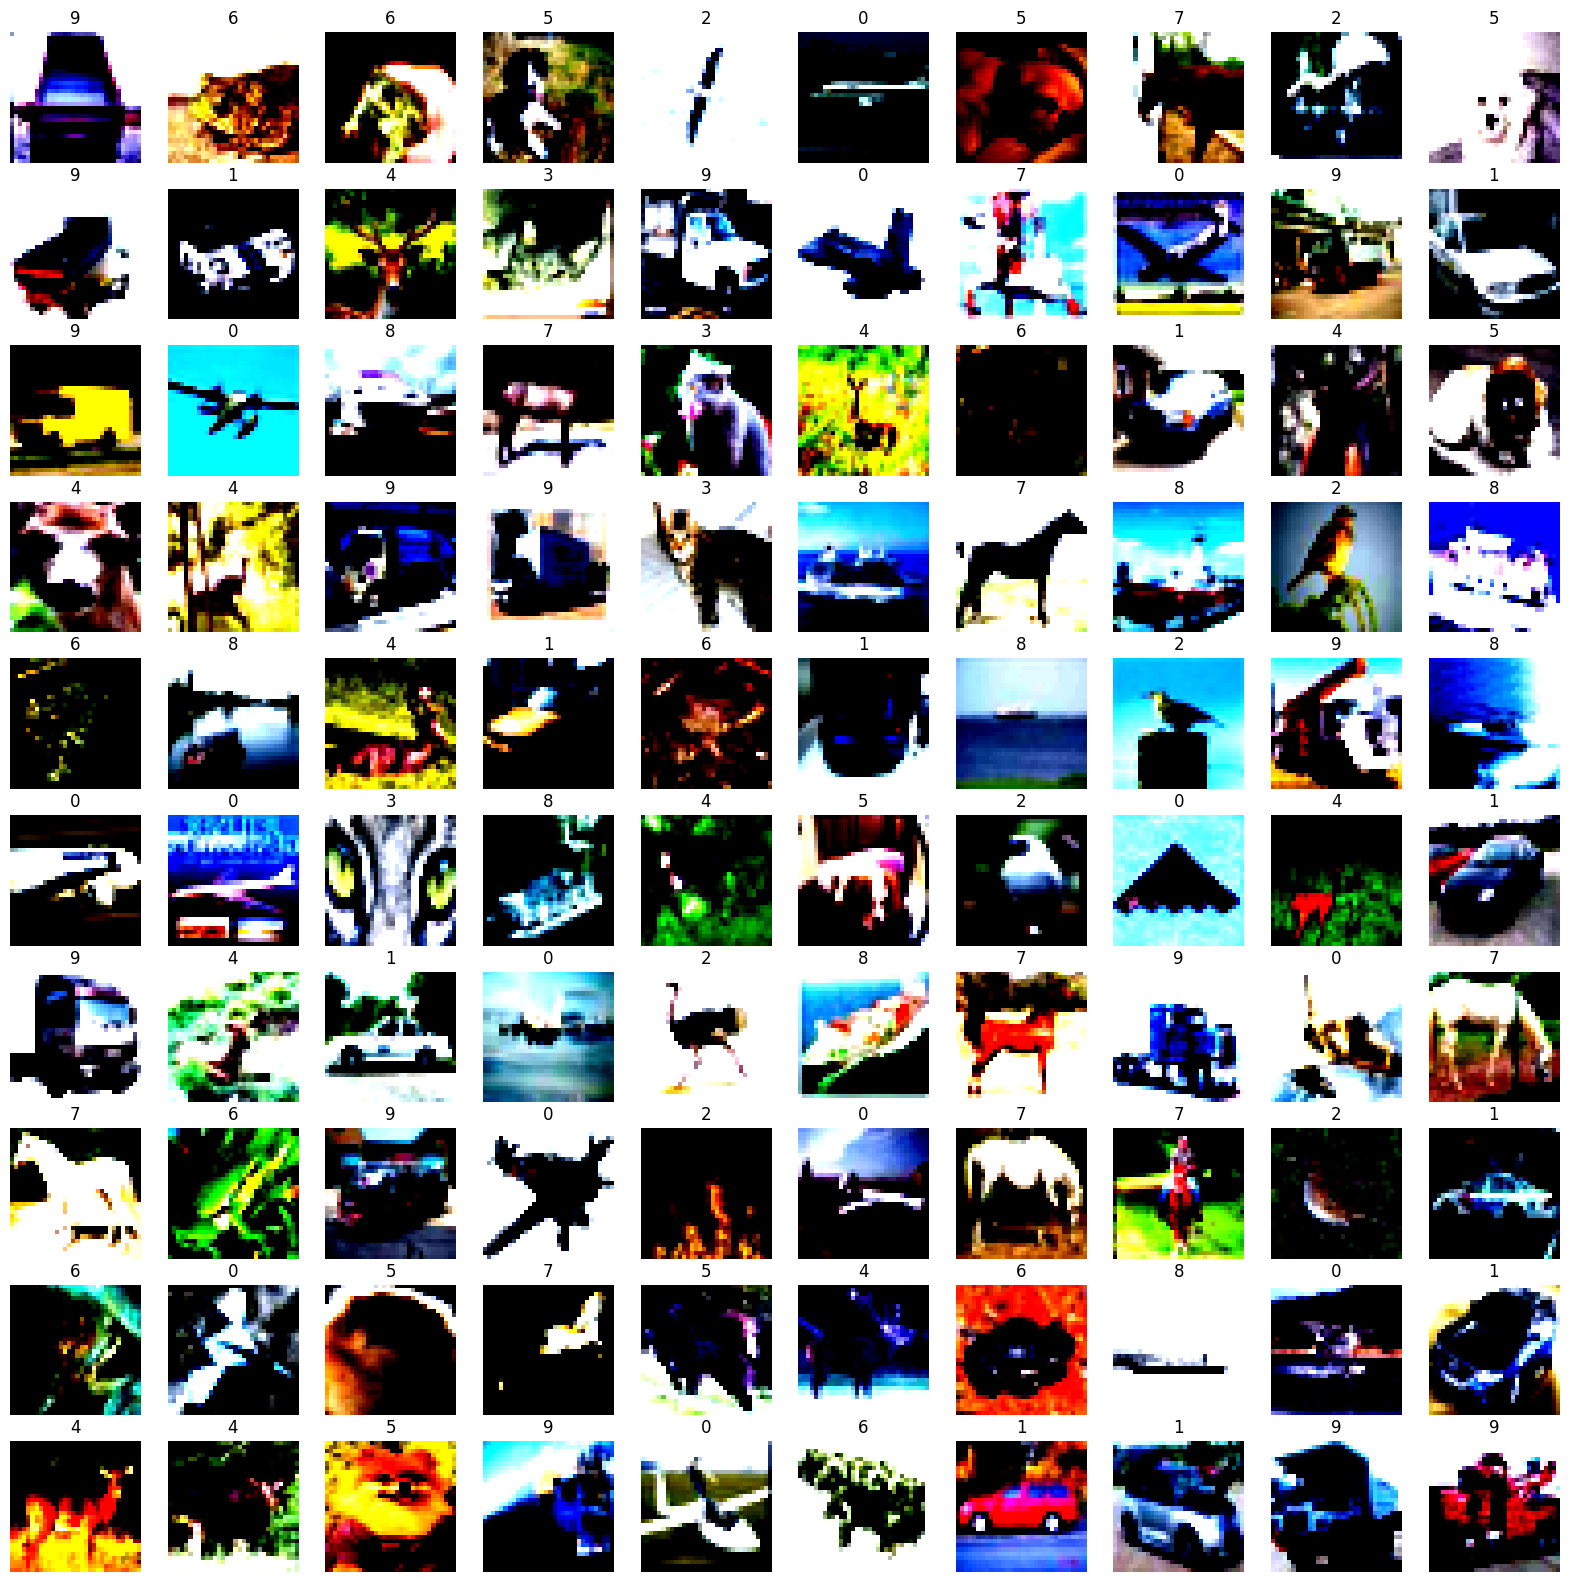

In [8]:
show_batch(train_loader)

In [9]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [10]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct/total

In [11]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 


# TODO: refine the training function from above
# it should contain:
# - saving of losses
# - calculation of accuracy
# - returning the mean loss and accuracy
    
def train(dataloader, optimizer, model, loss_fn, device):
    """ method to train the model """
    model_in_gpu = model.to(device)
    model_in_gpu.train()
    losses_train = []
    correct = 0
    total = 0
    for i, (x, y) in enumerate(dataloader):
            # delete the gradients from last training iteration
            optimizer.zero_grad()

            # Forward pass: get predictions
            y_pred = model_in_gpu(x.to(device))

            # Compute loss
            loss = loss_fn(y_pred,y.to(device))
            losses_train.append(loss.cpu().detach().numpy())
            
            #calculate accuracy
            correct += torch.sum((torch.argmax(y_pred,1) == y.to(device)))
            #add the batchsize to the total
            total += x.shape[0]

            # Backward pass -> calculate gradients, update weights
            loss.backward()
            optimizer.step()
        
    return (np.mean(losses_train), accuracy(correct.cpu().detach().numpy(),total))
   
            
            
def validate(dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function:
    model_in_gpu = model.to(device)
    model_in_gpu.eval()
    loss_val = []
    correct = 0
    total = 0
    for i, (x, y) in enumerate(dataloader):
        # Forward pass: get predictions
        with torch.no_grad():
            y_pred = model_in_gpu(x.to(device))
        
        #Calculate accuracy
        
        #torch.argmax(ypred,1) calculates predicted class for each sample in batch
        correct += torch.sum((torch.argmax(y_pred,1) == y.to(device)))
        #add the batchsize to the total
        total += x.shape[0]
            
        # Compute loss
        loss = loss_fn(y_pred,y.to(device))
        loss_val.append(loss.cpu().detach().numpy())

            
    return (np.mean(loss_val), accuracy(correct.cpu().detach().numpy(),total))

In [12]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_fn, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for epoch in trange(num_epochs):
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_fn, device)
        val_loss, val_acc = validate(val_dataloader, model, loss_fn, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    return (np.array(train_losses),np.array(train_accs),np.array(val_losses),np.array(val_accs))

In [39]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    model_in_gpu = model.to(device)
    model_in_gpu.eval()
    loss_val = []
    correct = 0
    total = 0
    number_classes = 10
    
    matrix = np.zeros(shape=(10,10))
    y_list = []
    y_pred_list = []
    for i, (x, y) in enumerate(dataloader):
        # Forward pass: get predictions
        with torch.no_grad():
            y_pred = model_in_gpu(x.to(device))
        
        y_pred = y_pred.cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        label_y_pred = np.argmax(y_pred,1)
    
        y_list.append(y.ravel())
        y_pred_list.append(label_y_pred)
    
    final_y_list = np.concatenate(y_list).ravel()
    final_y_pred_list = np.concatenate(y_pred_list).ravel()

    for i,(true,pred) in enumerate(zip(final_y_list,final_y_pred_list)):
        matrix[pred][true] +=1
                
    return matrix
            
            


## Logistic Regression   

In [14]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        self.layer1 = torch.nn.Linear(input_dim, output_dim)
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO: flatten the input to a suitable size for the initial layer
        x_flattend = torch.flatten(x,1) # then I would get 256 x 3*32*32
        # TODO: run the data through the layer
        logits = self.layer1(x_flattend)
        #use dimension 1 so that we get an array of 10 outputs
        outputs = torch.nn.Softmax(dim=1)(logits)
        
        return outputs

In [15]:
input1 = torch.randn(256,3, 32, 32)
# With default parameters
m = nn.Flatten()
output = m(input1)
output.size()

torch.Size([256, 3072])

In [16]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
input_dim = 32*32*3     #input dim is number of pixel values for each channel
output_dim = num_classes
linear_regression = LR(input_dim, output_dim)

In [17]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [18]:
# TODO: define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
num_epochs = 20
## TODO: run training over 20 epochs
#use test_dataloader as validation_dataloader
train_losses,train_accs,val_losses,val_accs=run_training(linear_regression, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

100%|██████████| 20/20 [07:45<00:00, 23.29s/it]


In [20]:
print(train_accs)
print("#######")
print(val_accs)

[0.36082 0.39384 0.4021  0.41132 0.41336 0.41842 0.4225  0.42272 0.42662
 0.42788 0.42858 0.43276 0.4345  0.43222 0.43472 0.43546 0.43886 0.43496
 0.43972 0.44092]
#######
[0.3877 0.3895 0.4017 0.4068 0.3991 0.4004 0.4001 0.4098 0.4068 0.4089
 0.4129 0.4132 0.4119 0.4126 0.4188 0.4108 0.4179 0.4137 0.417  0.4091]


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [21]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity

        super().__init__()
        self.model = torch.nn.Sequential(
                      torch.nn.Linear(input_dim,1650),
                      torch.nn.ReLU(),
                      torch.nn.Linear(1650,512),
                      torch.nn.ReLU(),
                      torch.nn.Linear(512,138),
                      torch.nn.ReLU(),
                      torch.nn.Linear(138,output_dim),
                      torch.nn.Softmax(dim=1)
                    )
        
    def forward(self, xb):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input
        x_flattend = torch.flatten(xb,1) # then I would get 256 x 3*32*32
        # TODO: run the data through the layer
        outputs = self.model(x_flattend)
        return outputs

In [22]:
## TODO: Define network, put it to device and train mode
mlp_model = MLP(input_dim, output_dim)
#model is placed into train mode in train function

In [23]:
## TODO: Define optimizer and loss functions
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
loss_fn_mlp = nn.CrossEntropyLoss()

In [24]:
## TODO: Train the MLP over 20 epochs
num_epochs = 20
train_losses_mlp,train_accs_mlp,val_losses_mlp,val_accs_mlp=run_training(mlp_model, optimizer_mlp, loss_fn_mlp, device, num_epochs, train_loader, test_loader)

100%|██████████| 20/20 [08:19<00:00, 24.97s/it]


In [25]:
print(val_accs_mlp)
print(train_accs_mlp)

[0.3359 0.2566 0.2807 0.2561 0.2772 0.2737 0.2012 0.2183 0.2072 0.2177
 0.2607 0.2056 0.2219 0.2207 0.2191 0.2279 0.2226 0.2033 0.2441 0.2445]
[0.30246 0.29226 0.282   0.28746 0.26748 0.27058 0.24336 0.21778 0.2081
 0.21144 0.25428 0.23688 0.22892 0.23068 0.2173  0.2238  0.21966 0.21064
 0.2181  0.24278]


## Add L2 regularisation

In [26]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
mlp_model_l2 = MLP(input_dim, output_dim)
optimizer_l2 = torch.optim.Adam(mlp_model_l2.parameters(), lr=0.001,weight_decay = 0.0005)
loss_fn_l2 = nn.CrossEntropyLoss()

In [27]:
## TODO: Retrain new model with regularization over 20 epochsnum_epochs = 20
train_losses_mlp_l2,train_accs_mlp_l2,val_losses_mlp_l2,val_accs_mlp_l2=run_training(mlp_model_l2, optimizer_l2, loss_fn_l2, device, num_epochs, train_loader, test_loader)

100%|██████████| 20/20 [08:20<00:00, 25.00s/it]


In [28]:
print(val_accs_mlp_l2)
print(train_accs_mlp_l2)

[0.3527 0.3661 0.3573 0.4019 0.3947 0.3789 0.4156 0.4135 0.4264 0.4312
 0.4214 0.4134 0.4457 0.4419 0.445  0.4549 0.4558 0.4579 0.4497 0.4645]
[0.30766 0.3376  0.36102 0.37808 0.39142 0.39488 0.40512 0.41476 0.42336
 0.42862 0.4298  0.43796 0.44514 0.44884 0.44336 0.45252 0.45866 0.4642
 0.46164 0.46464]


## LeNet5

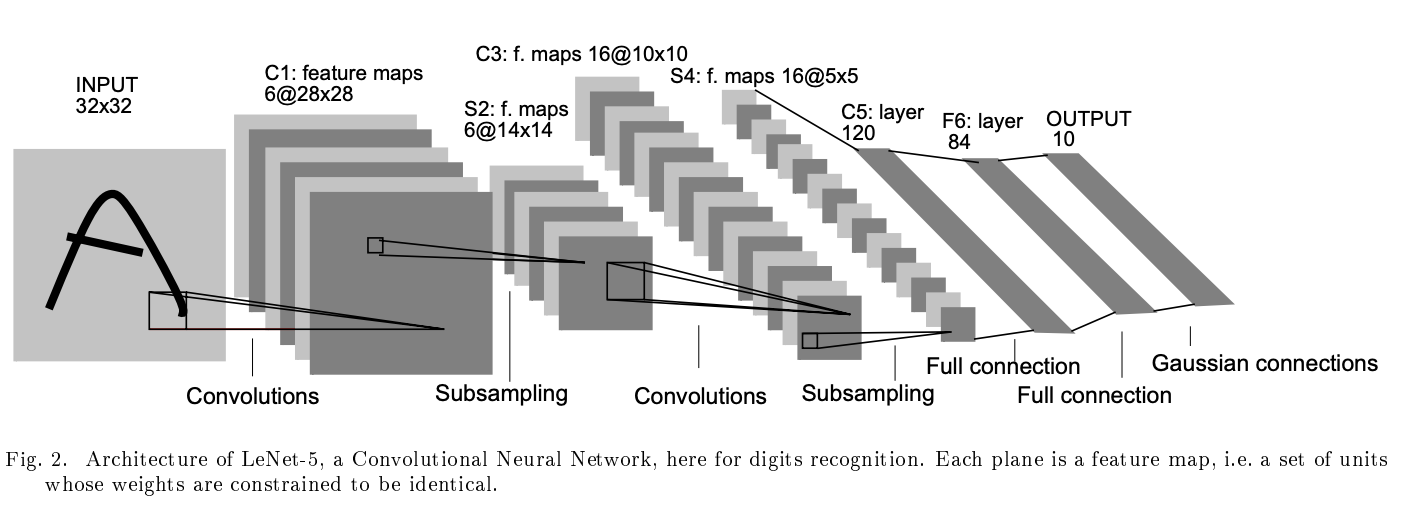

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [29]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),    
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
            nn.ReLU(),
            nn.Linear(in_features = 84, out_features = 10),
            nn.Softmax(dim=1)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [30]:
## TODO: define network, put it to the device and train mode
lenet5_model = LeNet5(n_classes=num_classes, in_channels = 3)
#model is placed into device and train mode in train function

In [31]:
## TODO: define loss function and optimisers
optimizer_lenet5 = torch.optim.Adam(lenet5_model.parameters(), lr=0.001)
loss_fn_lenet5 = nn.CrossEntropyLoss()

In [32]:
## TODO: train with 20 epochs
num_epochs = 20
train_losses_lenet5,train_accs_lenet5,val_losses_lenet5,val_accs_lenet5=run_training(lenet5_model, optimizer_lenet5, loss_fn_lenet5, device, num_epochs, train_loader, test_loader)

100%|██████████| 20/20 [09:05<00:00, 27.26s/it]


In [33]:
print(val_accs_lenet5)
print(train_accs_lenet5)

[0.3715 0.4146 0.4523 0.4567 0.467  0.4824 0.4863 0.4984 0.5103 0.516
 0.5341 0.539  0.5374 0.5394 0.5261 0.5523 0.5563 0.5717 0.5585 0.5734]
[0.2988  0.3961  0.4336  0.45566 0.46838 0.48296 0.49594 0.50976 0.51906
 0.52762 0.54048 0.54876 0.55362 0.55906 0.5637  0.56732 0.5773  0.5829
 0.58902 0.59268]


## Analysis 

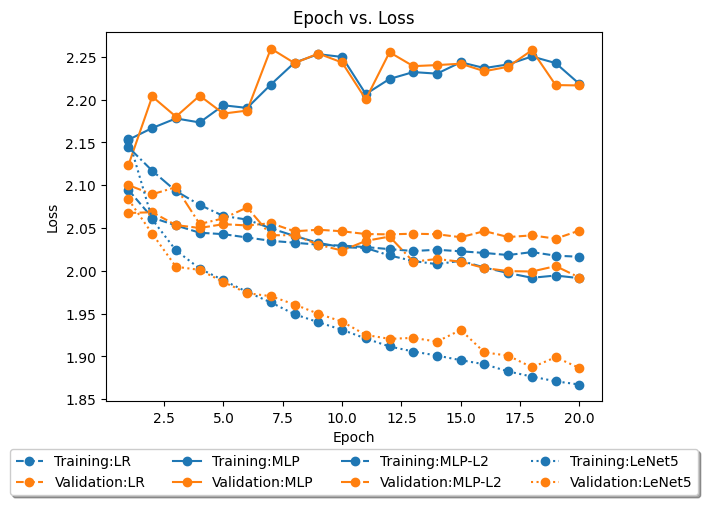

In [34]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

#attempt1 in plotting
epochs = np.arange(1,num_epochs +1)
plt.plot(epochs,train_losses, color='tab:blue', ls = "--", marker = 'o', label = "Training:LR")
plt.plot(epochs,val_losses, color = "tab:orange", ls = "--", marker = 'o', label = "Validation:LR")
plt.plot(epochs,train_losses_mlp, color='tab:blue', ls = "-", marker = 'o', label = "Training:MLP")
plt.plot(epochs,val_losses_mlp, color = "tab:orange", ls = "-", marker = 'o', label = "Validation:MLP")
plt.plot(epochs,train_losses_mlp_l2, color='tab:blue', ls = "-.", marker = 'o', label = "Training:MLP-L2")
plt.plot(epochs,val_losses_mlp_l2, color = "tab:orange", ls = "-.", marker = 'o', label = "Validation:MLP-L2")
plt.plot(epochs,train_losses_lenet5, color='tab:blue', ls = ":", marker = 'o', label = "Training:LeNet5")
plt.plot(epochs,val_losses_lenet5, color = "tab:orange", ls = ":", marker = 'o', label = "Validation:LeNet5")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs. Loss")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11),
          fancybox=True, shadow=True, ncol=4)
plt.show()

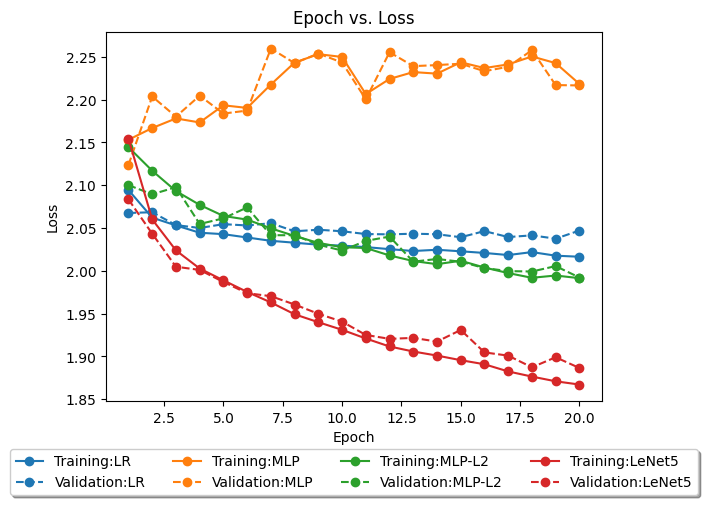

In [35]:
## TODO: Plot both train and val losses for all models. 
## What do you see?
epochs = np.arange(1,num_epochs +1)
plt.plot(epochs,train_losses, color='tab:blue', ls = "-", marker = 'o', label = "Training:LR")
plt.plot(epochs,val_losses, color = "tab:blue", ls = "--", marker = 'o', label = "Validation:LR")
plt.plot(epochs,train_losses_mlp, color='tab:orange', ls = "-", marker = 'o', label = "Training:MLP")
plt.plot(epochs,val_losses_mlp, color = "tab:orange", ls = "--", marker = 'o', label = "Validation:MLP")
plt.plot(epochs,train_losses_mlp_l2, color='tab:green', ls = "-", marker = 'o', label = "Training:MLP-L2")
plt.plot(epochs,val_losses_mlp_l2, color = "tab:green", ls = "--", marker = 'o', label = "Validation:MLP-L2")
plt.plot(epochs,train_losses_lenet5, color='tab:red', ls = "-", marker = 'o', label = "Training:LeNet5")
plt.plot(epochs,val_losses_lenet5, color = "tab:red", ls = "--", marker = 'o', label = "Validation:LeNet5")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs. Loss")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11),
          fancybox=True, shadow=True, ncol=4)
plt.show()

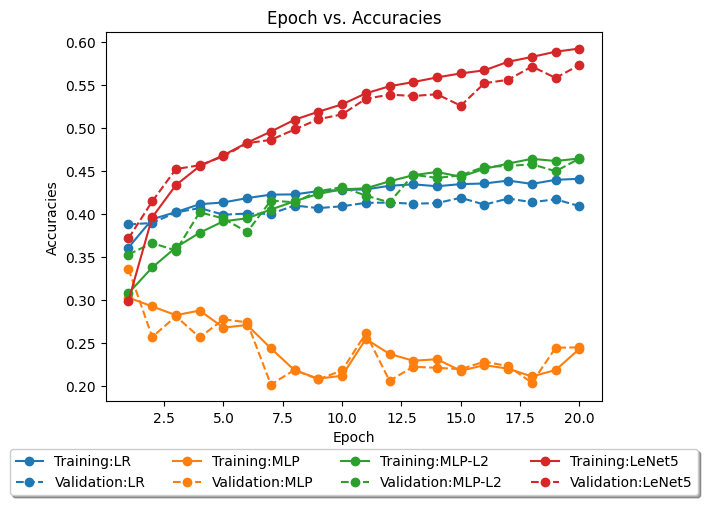

In [36]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?
epochs = np.arange(1,num_epochs +1)
plt.plot(epochs,train_accs, color='tab:blue', ls = "-", marker = 'o', label = "Training:LR")
plt.plot(epochs,val_accs, color = "tab:blue", ls = "--", marker = 'o', label = "Validation:LR")
plt.plot(epochs,train_accs_mlp, color='tab:orange', ls = "-", marker = 'o', label = "Training:MLP")
plt.plot(epochs,val_accs_mlp, color = "tab:orange", ls = "--", marker = 'o', label = "Validation:MLP")
plt.plot(epochs,train_accs_mlp_l2, color='tab:green', ls = "-", marker = 'o', label = "Training:MLP-L2")
plt.plot(epochs,val_accs_mlp_l2, color = "tab:green", ls = "--", marker = 'o', label = "Validation:MLP-L2")
plt.plot(epochs,train_accs_lenet5, color='tab:red', ls = "-", marker = 'o', label = "Training:LeNet5")
plt.plot(epochs,val_accs_lenet5, color = "tab:red", ls = "--", marker = 'o', label = "Validation:LeNet5")
plt.xlabel("Epoch")
plt.ylabel("Accuracies")
plt.title("Epoch vs. Accuracies")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11),
          fancybox=True, shadow=True, ncol=4)
plt.show()

In [40]:
## TODO: Plot the confusion matrix for LeNet5
confusion_matrix_lenet5 = calc_confusion_values(test_loader, lenet5_model, device)
confusion_matrix_lenet5

array([[633.,  39.,  64.,  28.,  43.,  12.,  11.,  32.,  94.,  33.],
       [ 39., 677.,  25.,   8.,  15.,   6.,  19.,  11.,  70., 137.],
       [ 66.,  19., 491.,  89., 190.,  82.,  74.,  43.,  18.,  10.],
       [ 10.,   9.,  66., 328.,  48., 153.,  40.,  40.,  16.,  26.],
       [ 15.,   5.,  58.,  50., 357.,  42.,  28.,  41.,  13.,   5.],
       [ 15.,   8.,  97., 203.,  61., 509.,  28.,  93.,  14.,  23.],
       [ 19.,  16.,  96., 150., 134.,  69., 748.,  36.,  12.,  29.],
       [ 25.,   8.,  60.,  70., 115.,  97.,  20., 654.,  15.,  39.],
       [119.,  43.,  20.,  21.,  23.,  11.,   8.,   8., 687.,  48.],
       [ 59., 176.,  23.,  53.,  14.,  19.,  24.,  42.,  61., 650.]])

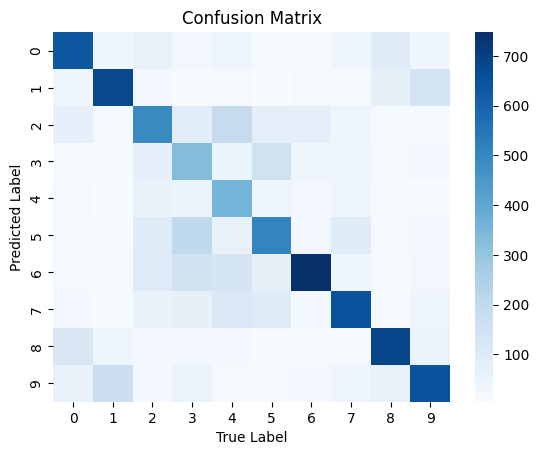

In [41]:
import seaborn as sns
sns.heatmap(confusion_matrix_lenet5, cmap=plt.cm.Blues)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [42]:
confusion_matrix_lenet5.sum()

10000.0

## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
